In [1]:
# Import the required packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sys
sys.path.append('..')
import alfw
from alfw import Face
import sklearn.metrics

<img src ="http://10.12.80.55:8880/files/deep-learning-keras-euroscipy2016/imgs/backprop.png" width="40%">

# Building Neural Nets from scratch from basic principles 

In [2]:
# Display plots inline 
%matplotlib inline
# Define plot's default figure size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
import random
random.seed(123)

## Start Building our ANN building blocks


<img src="http://10.12.80.55:8880/files/deep-learning-keras-euroscipy2016/imgs/mlp_details.png" width="45%" />

In [4]:
# calculate a random number where:  a <= rand < b
def rand(a, b):
    return (b-a)*random.random() + a

# Make a matrix 
def makeMatrix(I, J, fill=0.0):
    return np.zeros([I,J])

### Define our activation function. Let's use sigmoid function
<img src="http://rennsrdtacmapp03/wp01/www/assets/sigmoid.png" width="15%" />


In [10]:
def sigmoid(x):
    #return math.tanh(x)
    return 1/(1+np.exp(-x))

### Derivative of our activation function. 

Note: We need this when we run the backpropagation algorithm


In [11]:
# derivative of our sigmoid function, in terms of the output (i.e. y)
def dsigmoid(y):
    return y - y**2

### Neural networks class

In [2]:
# Putting all together

class ANN:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        print 1
        self.wo = makeMatrix(self.nh, self.no)
        
        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)

        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)
        

    def backPropagate(self, targets, N, M):
        
        if len(targets) != self.no:
            print(targets)
            raise ValueError('wrong number of target values')

        # calculate error terms for output
        output_deltas = np.zeros(self.no)
        for k in range(self.no):
            error = targets[k]-self.ao[k]
            output_deltas[k] = dsigmoid(self.ao[k]) * error

        # calculate error terms for hidden
        hidden_deltas = np.zeros(self.nh)
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error += output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k] * self.ah[j]
                self.wo[j][k] += N*change + M*self.co[j][k]
                self.co[j][k] = change

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] += N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5*(targets[k]-self.ao[k])**2
        return error


    def test(self, patterns):
        self.predict = np.empty([len(patterns), self.no])
        for i, p in enumerate(patterns):
            self.predict[i] = self.activate(p)
            #self.predict[i] = self.activate(p[0])
            
    def activate(self, inputs):
        
        if len(inputs) != self.ni-1:
            print 'inputs = ', (len(inputs))
            print 'ni=', (self.ni - 1)
                  
            raise ValueError('wrong number of inputs')

        # input activations
        for i in range(self.ni-1):
            self.ai[i] = inputs[i]

        # hidden activations
        for j in range(self.nh):
            sum_h = 0.0
            for i in range(self.ni):
                sum_h += self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum_h)

        # output activations
        for k in range(self.no):
            sum_o = 0.0
            for j in range(self.nh):
                sum_o += self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum_o)

        return self.ao[:]
    

    def train(self, patterns, iterations=1000, N=0.5, M=0.1):
        # N: learning rate
        # M: momentum factor
        patterns = list(patterns)
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.activate(inputs)
                error += self.backPropagate([targets], N, M)
            if i % 5 == 0:
                print('error in interation %d : %-.5f' % (i,error))
            #print('Final training error: %-.5f' % error)

### Running the model on our dataset

In [17]:
#read the datasets
train = pd.read_csv("deep-learning-keras-euroscipy2016/data/intro_to_ann.csv")

In [18]:
Xtrain, ytrain, ht, mm, Xtest, ytest, hts, mmt, (mean, std, meany, stdy, meani, stdi), scale, unscale, d = alfw.prepare(20000, onlyvisible=True)
print 'ytrain ', ytrain.shape    
print Xtrain.shape

print 'mean ', np.mean(Xtrain, axis=3).shape

# to grey
Xtrain = np.mean(Xtrain, axis=3).reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2], 1)
Xtest = np.mean(Xtest, axis=3).reshape(Xtest.shape[0], Xtest.shape[1], Xtest.shape[2], 1)
Xtest1 = Xtest

genders = np.asarray([x.genre == 'f' for x in d['md'][0]])
# normalize between 0 , 1
Xtrain, ytrain, ht = scale( Xtrain, ytrain, ht )
genders.shape

loading..
im.shape:  (20000, 128, 128, 3)
feats.shape: (20000, 28, 2)
hogs.shape: (20000, 8100)
goodmarks  (12, 20000, 2)
assert  0
mask  (20000,)
7708 20000
mmm  (20000, 12, 2)
385568
rim.shape:  (7708, 128, 128, 3)
rfeats.shape: (7708, 12, 2)
rhogs.shape: (7708, 8100)
(6937, 8100)
(8100,)
ytrain.shape  (6937, 12, 2)
meany.shape  (12, 2)
stdy.shape  (12, 2)
(6937, 128, 128, 3)
()
mmm  (6937, 12, 2)
ytrain  (6937, 12, 2)
(6937, 128, 128, 3)
mean  (6937, 128, 128)


(6937,)

### The data

### We have 500 samples of dimension 2 

In [26]:
X, y = np.array(train.ix[:,0:2]), np.array(train.ix[:,2])
print X.shape

(500, 2)


In [20]:
#ht.shape

In [21]:
N=Xtrain.shape[0]
Xtrain1 = np.reshape(Xtrain, (N, -1))
ytrain = np.reshape(ytrain, (N, -1))
print Xtrain1.shape
X,y = Xtrain1, genders[:] 
X.shape, y.shape

(6937, 16384)


((6937, 16384), (6937,))

In [22]:
X,y = ht, genders[:]
print X.shape
CC = 2
X,y = cv2.resize(ht, (CC,N)), genders[:]
print X.shape

X.shape

(6937, 8100)
(6937, 2)


(6937, 2)

In [23]:
y.shape

(6937,)

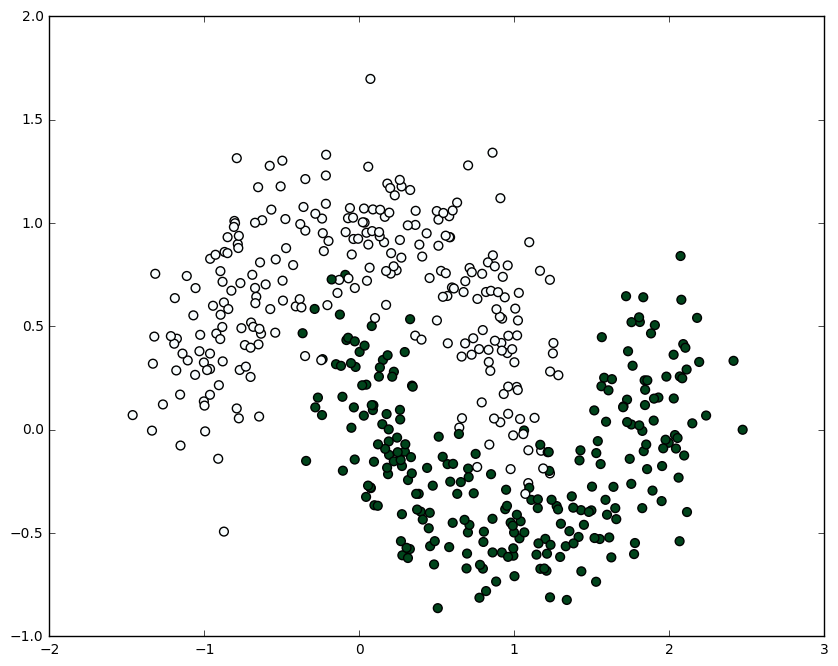

In [27]:
#Let's plot the dataset and see how it is
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.BuGn)

In [28]:
# create a network with two inputs, one hidden, and one output nodes
ann = ANN(X.shape[1], 5, 1)
print ann.ni
ann.train(zip(X,y), iterations=200)

3
error in interation 0 : 34.30597
error in interation 5 : 24.70103
error in interation 10 : 24.60335
error in interation 15 : 24.51670
error in interation 20 : 24.46245
error in interation 25 : 24.42830
error in interation 30 : 24.40478
error in interation 35 : 24.38648
error in interation 40 : 24.37056
error in interation 45 : 24.35567
error in interation 50 : 24.34126
error in interation 55 : 24.32717
error in interation 60 : 24.31342
error in interation 65 : 24.30007
error in interation 70 : 24.28714
error in interation 75 : 24.27465
error in interation 80 : 24.26252
error in interation 85 : 24.25057
error in interation 90 : 24.23846
error in interation 95 : 24.22545
error in interation 100 : 24.20993
error in interation 105 : 24.18787
error in interation 110 : 24.14746
error in interation 115 : 24.04652
error in interation 120 : 23.69189
error in interation 125 : 22.15958
error in interation 130 : 16.37375
error in interation 135 : 11.73240
error in interation 140 : 8.97874
error 

### Predicting on training dataset and measuring accuracy

In [29]:
%timeit -n 1 -r 1 ann.test(X)

1 loop, best of 1: 27.6 ms per loop


In [30]:
prediction = pd.DataFrame(data=np.array([y*1, np.ravel(ann.predict)]).T, 
                          columns=["actual", "prediction"])
prediction.head()

,actual,prediction
0,1.0,0.989322
1,1.0,0.997632
2,0.0,0.004947
3,0.0,0.034160
4,1.0,0.996994


In [31]:
np.min(prediction.prediction)
print ann.predict[:,0].shape, y.shape
sklearn.metrics.precision_score(y, ann.predict[:,0]>0.5)

(500,) (500,)


0.9642857142857143

### Let's visualize and observe the results

In [32]:


def plot_decision_boundary(nn_model):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    nn_model.test(np.c_[xx.ravel(), yy.ravel()])
    Z = nn_model.predict
    #seuillage
    Z[Z>=0.5] = 1
    Z[Z<0.5] = 0
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], s=40,  c=y, cmap=plt.cm.BuGn)

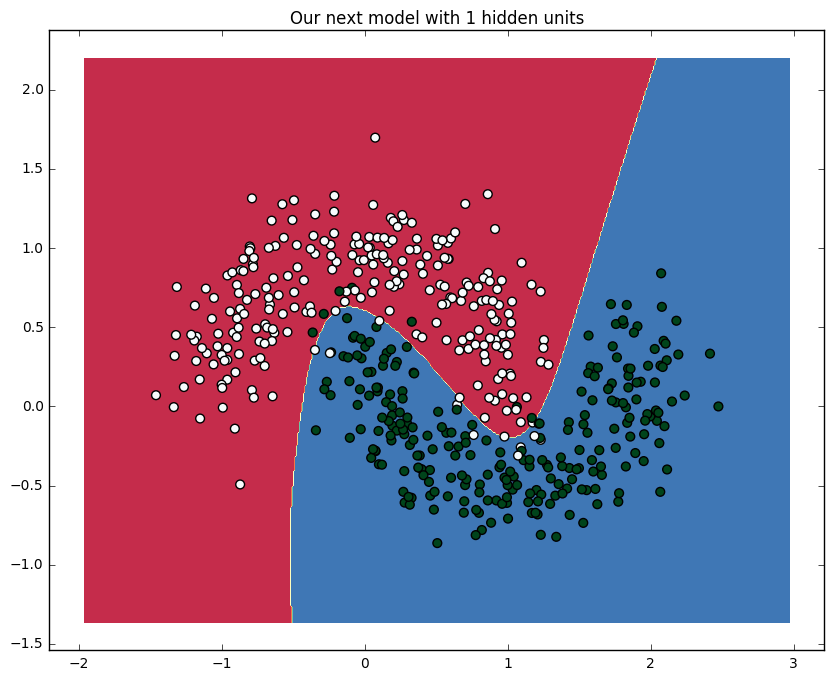

In [33]:


plot_decision_boundary(ann)
plt.title("Our next model with 1 hidden units")


In [3]:
reload alfw


SyntaxError: invalid syntax (<ipython-input-3-89aadd279688>, line 1)

In [4]:
reload(alfw)

<module 'alfw' from '../alfw.pyc'>